# Sugawara tank model

The Sugawara (Sugawara 1961) tank is an extension of the Linear Reservoir model which uses several (linear or non-linear) tanks. The flexibility in the selection of the number of tanks, and its response, provides a more complex representation of the phenomena, which not necessarily yields better simulation results. A 2 linear tanks Sugawara model is presented in Figure 4, however the configuration of the tanks is arbitrary and has to be defined by the modeller.

<img src='../figures/Sugawara1.png' width="400"></img>

Where P stands for precipitation and ET for evapotranspiration. S1 and S2 are the model states, represented by the water level in each of the tanks. d1 and d2 are the position of the outlets in the top tank. And k1to k4 represent the flux constants. Therefore, d and k are the model parameters to be determine during calibration. The description of the model components is presented in Table 1.

<img src='../figures/Sugawara2.png' width="400"></img>

Then we start importing all libraries including the file `sugawara.py`

# Study area

<img src='../figures/Study area.png' width="400"></img>

In [62]:
import pandas as pd
from joblib import load
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

import random
from deap import base, creator, tools, algorithms

# Model

In [197]:
def _step(prec, evap, st, param):

    # 旧状态
    S1Old = st[0]
    S2Old = st[1]

    # 参数
    k1, k2, k3, k4, d1, d2, rfcf, ecorr, Area = param

    ## 上层水箱
    H1 = np.max([S1Old + prec*rfcf - evap*ecorr, 0])

    if H1 > 0:
        # 直接径流
        q1 = k1*(H1-d1) if H1 > d1 else 0

        # 快速反应组分
        q2 =k2*(H1-d2) if H1 > d2 else 0

        # 渗透到下层水箱
        q3 = k3 * H1
        # 检查上层水箱中的水是否足够
        q123 = q1+q2+q3
        if q123 > H1:
            q1, q2, q3 = q1*q123/H1, q2*q123/H1, q3*q123/H1
    else:
        q1, q2, q3 = 0, 0, 0

    Q1 = q1+q2
    # 更新上层水箱状态
    S1New = max(H1 - (q1+q2+q3), 0.0)
    
    ## 下层水箱
    H2 = S2Old+q3
    Q2 = k4* H2

    # 检查是否有足够的水
    Q2 = H2 if Q2 > H2 else Q2

    # 更新下层水箱
    S2New = H2 - Q2

    ## 总流量
    Q = (Q1+Q2)* Area /86.4 if (Q1 + Q2) >= 0 else 0

    S = [S1New, S2New]
    return Q, S

def simulate(prec, evap, param, INITIAL_STATES=[10, 10], INITIAL_Q=1.0):
    '''
    这个函数模拟给定输入和参数的模型。
    prec: 降水量 [mm]
    evap: 蒸发量 [mm]
    param: 参数向量(8)
        k1: 上层水箱上部出水口系数
        k2: 上层水箱下部出水口系数
        k3: 渗透到下层水箱的系数
        k4: 下层水箱出水口系数
        d1: 上层水箱上部出水口位置
        d2: 上层水箱下部出水口位置
        rfcf: 降雨校正因子
        ecorr: 蒸发校正因子
        AREA: 流域面积 [km²]
    INITIAL_STATES: 初始状态的两个水箱
    INITIAL_Q: 初始流量
    
    输出：
    q: 流量 [m³/s]
    st: 更新的系统状态(2)[S1, S2] mm
    '''

    st = [INITIAL_STATES,]
    q = [INITIAL_Q,]

    for i in range(len(prec)):
        step_res = _step(prec[i], evap[i], st[i], param)
        q.append(step_res[0])
        st.append(step_res[1])

    return q,st

In [181]:
suzhou = pd.read_csv('../data/intermediate/suzhou_interpolated.csv', index_col=0, parse_dates=True)
precipitation = suzhou['precipitation']
water_level = suzhou['water_level']

mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0, parse_dates=True)
ETo = mete['ETo_PM']

In [182]:
# Load model from file
model = load('../data/intermediate/random_forest_model_w2d.joblib')

# Convert the date to datetime format and create a new feature 'days_since_start'
suzhou['date'] = pd.to_datetime(suzhou.index)
suzhou['days_since_start'] = (suzhou['date'] - suzhou['date'].min()).dt.days

discharge = model.predict(suzhou[['water_level','days_since_start']])
suzhou['discharge'] = discharge

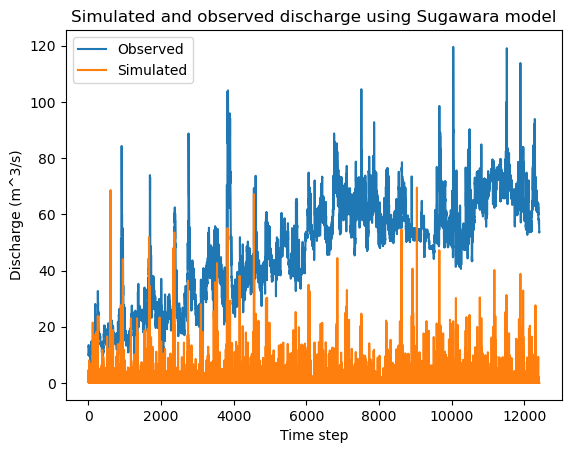

In [202]:
# 定义初始状态，初始流量和初始参数
INITIAL_STATES = [100, 100]  # 两个水箱的初始状态
INITIAL_Q = 30.0  # 初始流量
INITIAL_PARAM = [0.6, 0.1, 0.5, 0.5, 1.0, 1.0, 1, 1,30]  # 模型的初始参数

# 定义参数边界
PARAM_BND = ((0.0, 1.1),  # k1
             (0.0, 1.1),  # k2
             (0.0, 1.5),  # k3
             (0.0, 1.1),  # k4
             (1.0, 15.0),  # d1
             (0.1, 1.0),  # d2
             (0.7, 1.2),  # rfcf
             (0.7, 1.2),
             (0,200))  # ecorr

# 调用模型
discharge_predicted, _ = simulate(precipitation, ETo, INITIAL_PARAM)

# Plot the simulated discharge and observed discharge
plt.plot(discharge, label='Observed')
plt.plot(discharge_predicted, label='Simulated')
plt.xlabel('Time step')
plt.ylabel('Discharge (m^3/s)')
plt.title('Simulated and observed discharge using Sugawara model')
plt.legend()
plt.show()

# Calibrate the model

In [203]:
from scipy.optimize import minimize

# 定义目标函数
def objective(params):
    # 使用给定的参数运行模型
    discharge_predicted, _ = simulate(precipitation, ETo, params)
    # 剔除初始流量
    discharge_predicted = discharge_predicted[1:]
    # 计算预测值与观测值之间的均方误差
    mse = ((discharge_predicted - discharge) ** 2).mean()
    return mse


# 使用优化算法找到最小化目标函数的参数值
result = minimize(objective, INITIAL_PARAM, bounds=PARAM_BND)

# 打印优化结果
print('Optimized parameters:', result.x)


Optimized parameters: [0.00000000e+00 2.74382757e-01 1.50000000e+00 3.65951407e-03
 1.00000000e+00 1.00000000e-01 1.20000000e+00 7.00000000e-01
 2.00000000e+02]


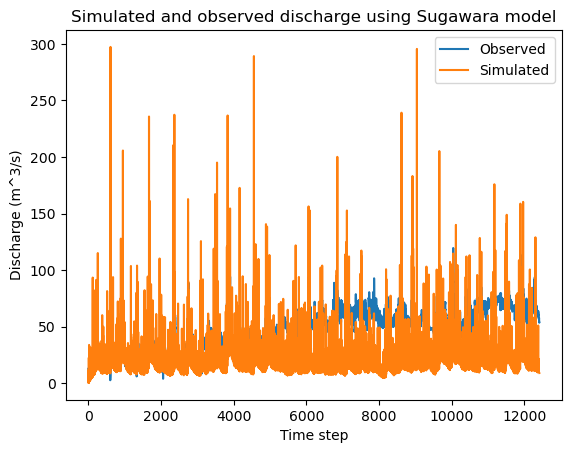

In [201]:
discharge_predicted, _ = simulate(precipitation, ETo, result.x)

# Plot the simulated discharge and observed discharge
plt.plot(discharge, label='Observed')
plt.plot(discharge_predicted, label='Simulated')
plt.xlabel('Time step')
plt.ylabel('Discharge (m^3/s)')
plt.title('Simulated and observed discharge using Sugawara model')
plt.legend()
plt.show()

# Tank Model (考虑surface runoff)

In [63]:
mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0, parse_dates=True)
fengqiao = pd.read_csv('../data/intermediate/fengqiao_processed.csv', index_col=0, parse_dates=True)

In [64]:
def tank_model(precip, et, k1, k2,k3, A, kc, initial_storage1=0, initial_storage2=0):
    n = len(precip)
    storage1 = np.zeros(n)
    storage2 = np.zeros(n)
    outflow = np.zeros(n)
    surface_runoff = np.zeros(n)
    baseflow = np.zeros(n)
    
    storage1[0] = initial_storage1
    storage2[0] = initial_storage2
    
    for t in range(1, n):
        # 计算实际蒸散发
        et_actual = et[t] * kc
        
        # 第一个水箱（上游水箱）处理降水和蒸散发
        storage1[t] = storage1[t-1] + precip[t] * A / 86.4 - et_actual * A / 86.4
        
        # 当存储量小于0时，将其设置为0
        storage1[t] = max(0, storage1[t])
                
        # 第一个水箱的出流
        surface_runoff[t] = k1 * storage1[t]
        storage1[t] -= surface_runoff[t]
        
        # 第二个水箱（下游水箱）处理出流
        inflow = k2 * storage1[t]
        storage1[t] -= inflow
        storage2[t] = storage2[t-1] + inflow
        baseflow[t] = k3 * storage2[t]
        storage2[t] -= baseflow[t]
        
        # 总出流是第一个水箱和第二个水箱的出流之和
        outflow[t] = surface_runoff[t] + baseflow[t]       
        
    return surface_runoff, baseflow, outflow

def model_error(k1, k2,k3, A, kc, initial_storage1, initial_storage2, precip, et, discharge):
    _, _, outflow = tank_model(precip, et, k1, k2,k3 , A, kc, initial_storage1, initial_storage2)
    mse = mean_squared_error(discharge, outflow)
    return -mse  # 取负值，因为我们希望最大化贝叶斯优化函数

# 定义参数搜索范围
param_bounds = {
    'kc': (0.1, 1.5),
    'k1': (0.00, 0.6),
    'k2': (0.01, 0.5),
    'k3': (0.01, 0.5),
    'A': (0, 3690),
    'initial_storage1': (0, 100),  # 假设初始存储量1的范围为0到100000立方米
    'initial_storage2': (0, 100),  # 假设初始存储量2的范围为0到100000立方米
}


## 使用贝叶斯优化算法找到最优参数

|   iter    |  target   |     A     | initia... | initia... |    k1     |    k2     |    k3     |    kc     |
-------------------------------------------------------------------------------------------------------------
| 1         | -6.168e+0 | 1.382e+03 | 95.07     | 73.2      | 0.3592    | 0.08645   | 0.08644   | 0.1813    |
| 2         | -2.788e+0 | 3.196e+03 | 60.11     | 70.81     | 0.01235   | 0.4853    | 0.4179    | 0.3973    |
| 3         | -2.54e+03 | 670.9     | 18.34     | 30.42     | 0.3149    | 0.2217    | 0.1527    | 0.9566    |
| 4         | -2.238e+0 | 514.7     | 29.21     | 36.64     | 0.2736    | 0.3947    | 0.1078    | 0.8199    |
| 5         | -4.37e+03 | 2.186e+03 | 4.645     | 60.75     | 0.1023    | 0.04188   | 0.475     | 1.452     |
| 6         | -2.818e+0 | 2.983e+03 | 30.46     | 9.767     | 0.4105    | 0.2257    | 0.0698    | 0.7932    |
| 7         | -2.853e+0 | 126.9     | 90.93     | 25.88     | 0.3975    | 0.1627    | 0.2648    | 0.8654    |
| 8       

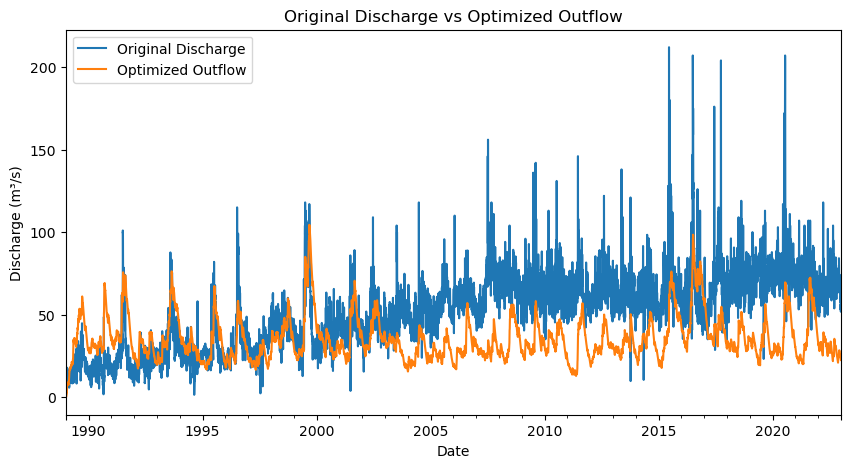

In [65]:
# 创建优化器
optimizer = BayesianOptimization(
    f=lambda k1, k2, k3, A, initial_storage1, initial_storage2, kc: model_error(k1, k2, k3, A, kc, initial_storage1, initial_storage2, fengqiao['precipitation'], mete['ETo_PM'], fengqiao['discharge']),
    pbounds=param_bounds,
    random_state=42,
)

# 执行优化
optimizer.maximize(init_points=10, n_iter=50)

# 获取最佳参数
best_params = optimizer.max['params']

# 使用最佳参数重新运行模型
kc_opt = best_params['kc']
k1_opt = best_params['k1']
k2_opt = best_params['k2']
k3_opt = best_params['k3']
A_opt = best_params['A']
initial_storage1_opt = best_params['initial_storage1']
initial_storage2_opt = best_params['initial_storage2']
surface_runoff_opt,baseflow_opt, outflow_opt = tank_model(fengqiao['precipitation'], mete['ETo_PM'], k1_opt, k2_opt,k3_opt, A_opt, kc_opt, initial_storage1_opt, initial_storage2_opt)

# 将优化后的结果存储在一个新的DataFrame中
tank_results_opt = pd.DataFrame({'Date': mete.index, 'Surface_runoff': surface_runoff_opt, 'Baseflow': baseflow_opt, 'Outflow': outflow_opt})
tank_results_opt.set_index('Date', inplace=True)

# Calculate the mean squared error between the original and optimized discharge
mse = mean_squared_error(fengqiao['discharge'], tank_results_opt['Outflow'])

print(tank_results_opt)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# 绘制原始的discharge数据
fengqiao['discharge'].plot(ax=ax, label='Original Discharge')
print('Mean Squared Error:', mse)
# 绘制优化后的Outflow数据
tank_results_opt['Outflow'].plot(ax=ax, label='Optimized Outflow')

ax.set_title('Original Discharge vs Optimized Outflow')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m³/s)')
ax.legend()

plt.show()

## 使用differential_evolution优化

In [37]:
from scipy.optimize import differential_evolution

precip = fengqiao['precipitation']
discharge = fengqiao['discharge']
et = mete['ETo_PM']

# Define the bounds of the parameters as a list of tuples
param_bounds = {
    'kc': (0.1, 1.5),
    'k1': (0.00, 0.6),
    'k2': (0.01, 0.5),
    'k3': (0.01, 0.5),
    'A': (0, 200000000),
    'initial_storage1': (0, 10000),  # 假设初始存储量1的范围为0到100000立方米
    'initial_storage2': (0, 10000),  # 假设初始存储量2的范围为0到100000立方米
}

# Define an error function that receives a list of parameters
def model_error(params):
    kc, k1, k2, k3, A, initial_storage1, initial_storage2 = params
    _, _, outflow = tank_model(precip, et, k1, k2, k3, A, kc, initial_storage1, initial_storage2)
    mse = mean_squared_error(discharge, outflow)
    return mse  # For Differential Evolution, we minimize the function

# Perform the optimization
result = differential_evolution(model_error, bounds)

# Print the result
print(result.x)

[1.00000000e-01 1.74316687e-02 5.00000000e-01 1.00000000e-02
 1.35790261e+03 3.22466245e+02 2.74627420e+02]


0.1 0.02 0.5 0.01 1357.9 322.47 274.63
            Surface_runoff   Baseflow    Outflow
Date                                            
1989-01-01        0.000000   0.000000   0.000000
1989-01-02        6.391878   4.312310  10.704188
1989-01-03        3.081728   5.024210   8.105938
1989-01-04        1.471070   5.334380   6.805450
1989-01-05        0.942740   5.512008   6.454748
...                    ...        ...        ...
2022-12-27        0.000000  31.959343  31.959343
2022-12-28        0.000000  31.639749  31.639749
2022-12-29        0.000000  31.323352  31.323352
2022-12-30        0.000000  31.010118  31.010118
2022-12-31        0.000000  30.700017  30.700017

[12418 rows x 3 columns]
Mean Squared Error: 607.8015479597132


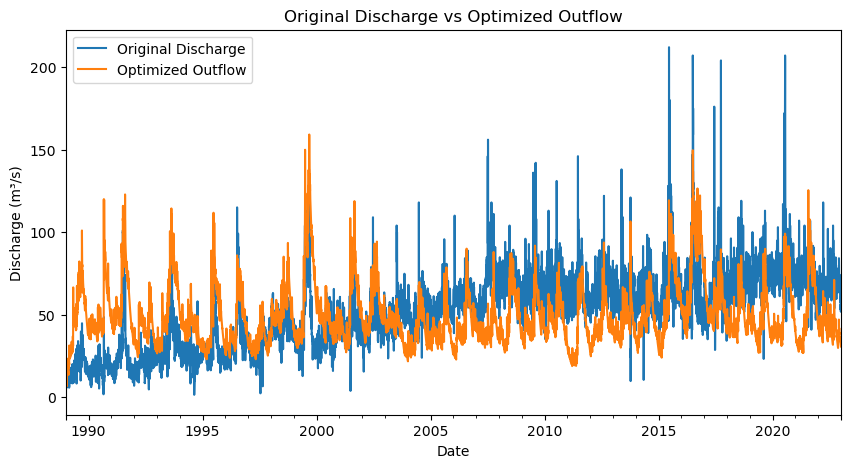

In [40]:
# 使用最佳参数重新运行模型
kc_opt, k1_opt, k2_opt, k3_opt, A_opt, initial_storage1_opt, initial_storage2_opt = np.round(result.x,2)
print(kc_opt, k1_opt, k2_opt, k3_opt, A_opt, initial_storage1_opt, initial_storage2_opt)
surface_runoff_opt,baseflow_opt, outflow_opt = tank_model(fengqiao['precipitation'], mete['ETo_PM'], k1_opt, k2_opt,k3_opt, A_opt, kc_opt, initial_storage1_opt, initial_storage2_opt)

# 将优化后的结果存储在一个新的DataFrame中
tank_results_opt = pd.DataFrame({'Date': mete.index, 'Surface_runoff': surface_runoff_opt, 'Baseflow': baseflow_opt, 'Outflow': outflow_opt})
tank_results_opt.set_index('Date', inplace=True)

# Calculate the mean squared error between the original and optimized discharge
mse = mean_squared_error(fengqiao['discharge'], tank_results_opt['Outflow'])

print(tank_results_opt)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# 绘制原始的discharge数据
fengqiao['discharge'].plot(ax=ax, label='Original Discharge')
print('Mean Squared Error:', mse)
# 绘制优化后的Outflow数据
tank_results_opt['Outflow'].plot(ax=ax, label='Optimized Outflow')

ax.set_title('Original Discharge vs Optimized Outflow')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m³/s)')
ax.legend()

plt.show()

# Tank Model (surface runoff + subsurface runoof + baseflow)

|   iter    |  target   |     A     |    d1     |    d2     |    k1     |    k2     |    k3     |    k4     |    kc     |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -1.954e+0 | 1.382e+03 | 95.07     | 73.2      | 0.005987  | 0.1092    | 0.156     | 0.05808   | 0.8662    |
| 2         | -2.941e+0 | 2.218e+03 | 70.81     | 2.058     | 0.009699  | 0.5827    | 0.2123    | 0.1818    | 0.1834    |
| 3         | -5.342e+0 | 1.123e+03 | 52.48     | 43.19     | 0.002912  | 0.4283    | 0.1395    | 0.2921    | 0.3664    |
| 4         | -1.184e+0 | 1.683e+03 | 78.52     | 19.97     | 0.005142  | 0.4147    | 0.04645   | 0.6075    | 0.1705    |
| 5         | -2.615e+0 | 240.0     | 94.89     | 96.56     | 0.008084  | 0.2132    | 0.09767   | 0.6842    | 0.4402    |
| 6         | -2.312e+0 | 450.3     | 49.52     | 3.439     | 0.009093  | 0.1811    | 0.6625    | 0.3117    | 0.5201    |
| 7         | -3.254e+0 

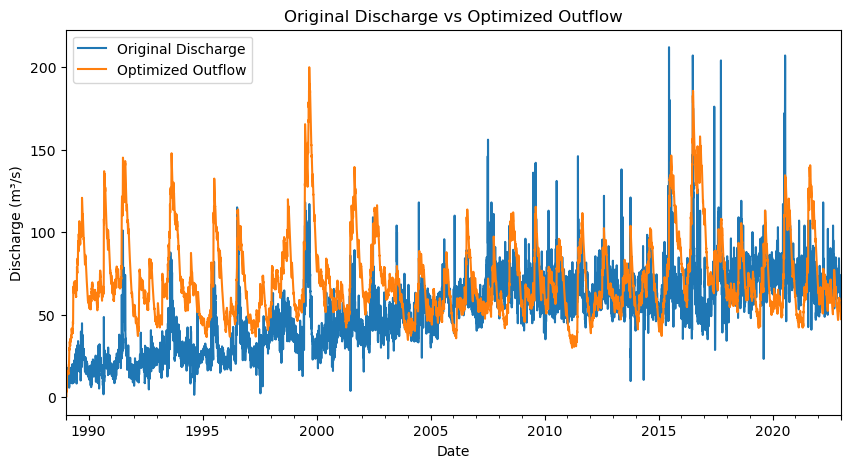

In [57]:
def model_error(k1, k2, k3, k4, d1, d2, A, kc, precip, et, discharge):
    # Run the model with the given parameters
    surface_runoff, subsurface_runoff, baseflow, outflow = tank_model(precip, et, k1, k2, k3, k4, d1, d2, A, kc)
    mse = mean_squared_error(discharge, outflow)
    return -mse  # 取负值，因为我们希望最大化贝叶斯优化函数

# 定义参数搜索范围
param_bounds = {
    'k1': (0, 0.01),
    'k2': (0, 0.7),
    'k3': (0, 1),
    'k4': (0, 1),
    'd1': (0, 100),
    'd2': (0, 100),
    'A': (0, 3690),
    'kc': (0, 1),
}

# 创建优化器
optimizer = BayesianOptimization(
    f=lambda k1, k2, k3, k4, d1, d2, A, kc: model_error(k1, k2, k3, k4, d1, d2, A, kc, fengqiao['precipitation'], mete['ETo_PM'], fengqiao['discharge']),
    pbounds=param_bounds,
    random_state=42,
)

# 执行优化
optimizer.maximize(init_points=10, n_iter=50)

# 获取最佳参数
best_params = optimizer.max['params']

# 使用最佳参数重新运行模型
kc_opt = best_params['kc']
k1_opt = best_params['k1']
k2_opt = best_params['k2']
k3_opt = best_params['k3']
k4_opt = best_params['k4']
d1_opt = best_params['d1']
d2_opt = best_params['d2']
A_opt = best_params['A']
surface_runoff_opt, subsurface_runoff_opt, baseflow_opt, outflow_opt = tank_model(fengqiao['precipitation'], mete['ETo_PM'], k1_opt, k2_opt, k3_opt, k4_opt, d1_opt, d2_opt, A_opt, kc_opt)

# 将优化后的结果存储在一个新的DataFrame中
tank_results_opt = pd.DataFrame({'Date': mete.index, 'Surface_runoff': surface_runoff_opt, 'Subsurface_runoff': subsurface_runoff_opt, 'Baseflow': baseflow_opt, 'Outflow': outflow_opt})
tank_results_opt.set_index('Date', inplace=True)

# Calculate the mean squared error between the original and optimized discharge
mse = mean_squared_error(fengqiao['discharge'], tank_results_opt['Outflow'])

print(tank_results_opt)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# 绘制原始的discharge数据
fengqiao['discharge'].plot(ax=ax, label='Original Discharge')
print('Mean Squared Error:', mse)
# 绘制优化后的Outflow数据
tank_results_opt['Outflow'].plot(ax=ax, label='Optimized Outflow')

ax.set_title('Original Discharge vs Optimized Outflow')
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m³/s)')
ax.legend()


plt.show()

# 结论

最终选择使用Tank Model (surface runoff + baseflow)的结果，因为它的MSE最小。

In [ ]:
def tank_model_land_expand(precip, et, k1, k2, A, kc, Land_expand, initial_storage1=0, initial_storage2=0):
    n = len(precip)
    storage1 = np.zeros(n)
    storage2 = np.zeros(n)
    outflow = np.zeros(n)

    storage1[0] = initial_storage1
    storage2[0] = initial_storage2

    # 生成与降水数据长度相同的序列
    expand_factors = np.zeros(n)
    years_per_interval = 5
    for i, expand_factor in enumerate(Land_expand):
        start = i * years_per_interval * 365
        end = min((i + 1) * years_per_interval * 365, n)
        expand_factors[start:end] = expand_factor

    for t in range(1, n):
        # 计算实际蒸散发
        et_actual = et[t] * kc

        # 根据扩张系数调整k1参数
        adjusted_k1 = k1 * (1 + expand_factors[t])

        # 第一个水箱（上游水箱）处理降水和蒸散发
        storage1[t] = storage1[t-1] + precip[t] * A / 86400 - et_actual * A / 86400

        # 当存储量小于0时，将其设置为0
        storage1[t] = max(0, storage1[t])

        # 第二个水箱（下游水箱）处理出流
        inflow = adjusted_k1 * storage1[t]
        storage1[t] -= inflow
        storage2[t] = storage2[t-1] + inflow
        outflow[t] = k2 * storage2[t]
        storage2[t] -= outflow[t]

    return storage1, storage2, outflow

def model_error(k1, k2, A, kc, initial_storage1, initial_storage2, Land_expand, precip, et, discharge):
    _, _, outflow = tank_model(precip, et, k1, k2, A, kc, Land_expand, initial_storage1, initial_storage2)
    mse = mean_squared_error(discharge, outflow)
    return mse

# 城市扩张方程

In [60]:
import pandas as pd

data = {
    'Year': [2000, 2005, 2010, 2015, 2018],
    'Land_Expand': [0.1698, 0.2377, 0.4078, 0.4406, 0.4519]
}

df = pd.DataFrame(data)

In [61]:
from sklearn.linear_model import LinearRegression

# 创建线性回归模型
model = LinearRegression()

# 使用年份和土地扩张数据来拟合模型
model.fit(df[['Year']], df['Land_Expand'])

# 打印模型参数
print("Intercept: ", model.intercept_)
print("Coefficient: ", model.coef_[0])

Intercept:  -33.73133996247656
Coefficient:  0.016955065666041283
